In [2]:
import torchvision

from datasets import KeyboardBBoxDataset
from datasets.util import *
from utils import get_device

In [3]:
device = get_device()
device

'mps'

In [4]:
DATASET_VERSION = 2
image_paths = get_dataset_paths(DATASET_VERSION)
len(image_paths)

1000

In [5]:
mean, std = get_dataset_norm_params(DATASET_VERSION)
mean, std

(array([0.2517634 , 0.26364404, 0.27402246]),
 array([0.241223  , 0.24496816, 0.25682035]))

In [6]:
train_paths, test_paths, valid_paths = split_train_test_valid(image_paths, 0.8, 0.16)

train_dataset = KeyboardBBoxDataset(train_paths)
valid_dataset = KeyboardBBoxDataset(valid_paths)
test_dataset = KeyboardBBoxDataset(test_paths)

len(train_dataset), len(valid_dataset), len(test_dataset)

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(640, 160, 200)

In [7]:
from torchvision.transforms import v2 as transforms

train_dataset.set_transforms([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    # transforms.RandomErasing(p=0.5),
    transforms.ToPureTensor(),
])

train_dataset.set_augmentations([
    transforms.RandomChannelPermutation(),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std)
])

{'boxes': tensor([[252,   0, 259,   2],
         [ 49,   0,  71,   9],
         [  0,   0,  18,  34],
         [351,   0, 419,  39],
         [158,   0, 233,  41],
         [272,   0, 342,  57],
         [437,   0, 523,  62],
         [ 78,   0, 156,  66],
         [394,  20, 459,  90],
         [209,  21, 281,  94],
         [318,  37, 386, 108],
         [  0,  35,  75, 111],
         [133,  46, 207, 119],
         [498,  43, 571, 125],
         [435,  71, 498, 138],
         [257,  74, 326, 144],
         [361,  89, 427, 156],
         [184,  99, 255, 169],
         [473, 119, 534, 183],
         [546, 107, 615, 184],
         [303, 125, 369, 192],
         [ 90, 126, 163, 197],
         [402, 137, 465, 202],
         [232, 149, 300, 216],
         [510, 165, 568, 227],
         [345, 172, 409, 237],
         [590, 166, 640, 239],
         [141, 177, 212, 244],
         [441, 183, 502, 245],
         [277, 197, 343, 261],
         [632, 244, 640, 265],
         [386, 217, 447, 279],

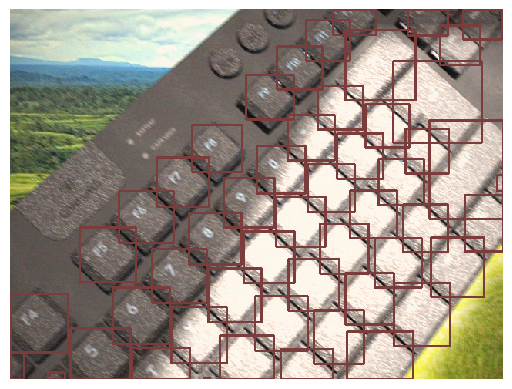

In [8]:
import random

i = random.randint(0, len(train_dataset) - 1)
train_dataset.show(i)
train_dataset[i][1]

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": True,
             "collate_fn": zip_collate_fn}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)
test_dataloader = DataLoader(test_dataset, **dl_kwargs)

In [10]:
import torch

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize


class KeyRegionDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
        backbone.out_channels = 1280
        
        # let's make the RPN generate 4 x 3 anchors per spatial
        # location, with 5 different sizes and 3 different aspect
        # ratios. We have a Tuple[Tuple[int]] because each feature
        # map could potentially have different sizes and
        # aspect ratios
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )
        
        # let's define what are the feature maps that we will
        # use to perform the region of interest cropping, as well as
        # the size of the crop after rescaling.
        # if your backbone returns a Tensor, featmap_names is expected to
        # be [0]. More generally, the backbone should return an
        # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
        # feature maps to use.
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=["0"],
            output_size=7,
            sampling_ratio=2
        )
        
        # put the pieces together inside a Faster-RCNN model
        self.rcnn = FasterRCNN(
            backbone,
            num_classes=2,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )

    def forward(self, *args):
        return self.rcnn(args)

    def _step(self, batch, stage):
        if trainer.global_step == 0:
            wandb.define_metric(f"{stage}_loss", summary="min")

        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        self.rcnn.train()
        loss_dict = self.rcnn(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        self.log(f"{stage}_loss", loss)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STEPS, eta_min=1e-5)
        return {"optimizer": optimizer}  # "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 1}

In [11]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


True

In [70]:
wandb.finish()
model = KeyRegionDetectionModel()
model

epoch,▁▁
train_loss,█▁
trainer/global_step,▁█
epoch,0
trainer/global_step,1


KeyRegionDetectionModel(
  (rcnn): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, aff

In [71]:
summarize(model)

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | rcnn | FasterRCNN | 82.3 M | train
--------------------------------------------
82.3 M    Trainable params
0         Non-trainable params
82.3 M    Total params
329.335   Total estimated model params size (MB)
228       Modules in train mode
0         Modules in eval mode

In [72]:
EPOCHS = 10
LEARNING_RATE = 3e-4

PROFILE = False
profiler = "advanced" if PROFILE else None

logger = WandbLogger(project="mrover-keyboard-region-detection", group=f"MobileNetV2")
logger.experiment.config["dataset"] = DATASET_VERSION

trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, profiler=profiler, logger=logger)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | rcnn | FasterRCNN | 82.3 M | train
--------------------------------------------
82.3 M    Trainable params
0         Non-trainable params
82.3 M    Total params
329.335   Total estimated model params size (MB)
228       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
Process Process-21:
Process Process-19:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/Library/Frameworks/Python.fr

NameError: name 'exit' is not defined

In [73]:
torch.save(model.state_dict(), f"models/binary_segmentation/{wandb.run.name}-FRCNN-MobileNetV2-v{DATASET_VERSION}.pt")
wandb.finish()

epoch,▁▁
train_loss,█▁
trainer/global_step,▁█
epoch,0
trainer/global_step,1


In [12]:
model = KeyRegionDetectionModel()
model.load_state_dict(
    torch.load(f"models/binary_segmentation/fresh-water-9-FRCNN-MobileNetV2-v{DATASET_VERSION}.pt", weights_only=True))
model.eval()

KeyRegionDetectionModel(
  (rcnn): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, aff

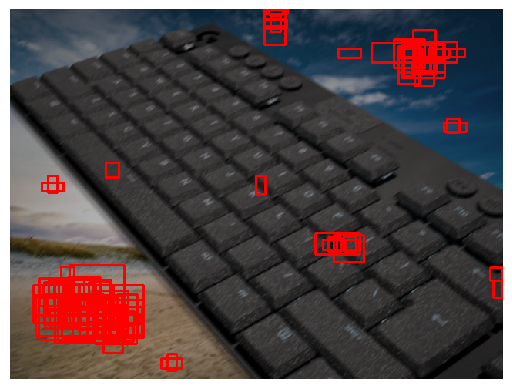

In [24]:
from utils import imshow
import cv2

img, _ = test_dataset[0]
out = model(img)[0]
img = reorder_image_axes(img.numpy()).copy()

for quad in out["boxes"]:
    x1, y1, x2, y2 = map(int, quad.detach().numpy())
    cv2.rectangle(img, (x1, y1), (x2, y2), (1.0, 0, 0), 2)

imshow(img)